# Sentiment Analysis Using Recurrent Neural Network (RNN)
## Jessica Schmidt

# PART I: Research Question

## A1. Research Question
Can we use a Recurrent Neural Network (RNN) to find the Sentiment Index among the reviews from Amazon, IMDB, and Yelp? 

Sentiment Index is essentially an economic measure of how a consumer feels about economic conditions - either optimistic or pessimistic - in this case, the market is Amazon, IMDB, and Yelp. (Source: Investopedia)

## A2. Objectives and Goals of the Analysis
The goal of this analysis is to create a RNN model that can find the Sentiment Index for the reviews from Amazon, IMDB, and Yelp.

## A3. Type of Neural Network for Classification Task (source: D213 Webinars)
For this task, we will use a Recurrent Neural Network (RNN). An RNN "is a class of neural networks that uses connections between neurons to form a directed cycle to create feedback." (D213 webinar.) It is frequently used for text classification and natural language processing. Additionally, RNN is useful because "unlike other networks, RNN can remember previous computation and reuse it for the next element." (D213) It works by 

# PART II: Data Preparation

## B1. Exploratory Data Analysis

In [1]:
# Disabling warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import unicodedata
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Confirming version of TensorFlow
print(tf.version.VERSION)

2.10.0


In [4]:
# Importing data for dataframe from Amazon, IMDB, and Yelp
colnames = ['text', 'label']
amazon = pd.read_csv('/Users/astro/Downloads/amazon_cells_labelled.txt', sep='\t', names=colnames, header=None)
imdb = pd.read_csv('/Users/astro/Downloads/imdb_labelled.txt', sep='\t', names=colnames, header=None)
yelp = pd.read_csv('/Users/astro/Downloads/yelp_labelled.txt', sep='\t', names=colnames, header=None)
df = pd.concat([amazon, imdb, yelp])
df = df.reset_index(drop=True)

In [5]:
# Examining dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2748 non-null   object
 1   label   2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [6]:
df.shape

(2748, 2)

In [7]:
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


## 1. Presence of unusual characters

In [8]:
def isEnglish(c):
    try:
        c.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [9]:
non_english = []
for index, row in df.iterrows():
    for l in list(row['text']):
        for c in l:
            if isEnglish(c) == True:
                pass
            else:
                non_english.append(c)
non_english[:10]

['\x96', 'é', '\x85', '\x96', 'é', 'é', 'å', '\x96', '\x97', '\x96']

In [10]:
df.head(100)

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
95,Will order from them again!,1
96,If you plan to use this in a car forget about it.,0
97,I found this product to be waaay too big.,0
98,Best I've found so far .... I've tried 2 other...,1


In [11]:
ADDITIONAL_STOPWORDS = []

def clean_sentence(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return word_list

In [12]:
def get_words(df, column):
    """
    Takes a dataframe and a column and returns a list of
    cleaned words that is returned by clean().

            Parameters:
                    df (dataframe): A pandas dataframe
                    column (series): A pandas series

            Returns:
                    word_list (list): A list of cleaned words
    """
    return clean_sentence(''.join(str(df[column].tolist())))

In [13]:
df_sat =  df.loc[df['label'] == 1]
df_dsat =  df.loc[df['label'] == 0]

In [14]:
all_words = get_words(df, 'text')
sat_words = get_words(df_sat, 'text')
dsat_words = get_words(df_dsat, 'text')

In [15]:
sat_freq = pd.Series(sat_words).value_counts()
dsat_freq = pd.Series(dsat_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

word_counts = (pd.concat([all_freq, sat_freq, dsat_freq], axis=1, sort=True)
                .set_axis(['all', 'sat', 'dsat'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

## 2. Vocabulary size

In [16]:
print('Satisfied reviews: ' + str(len(sat_freq)))
print('Dissatisfied reviews: ' + str(len(dsat_freq)))
print('All reviews: ' + str(len(all_freq)))

Satisfied reviews: 3102
Dissatisfied reviews: 3197
All reviews: 4967


In [17]:
vocab_size = len(all_freq)
vocab_size

4967

## 3 and 4. Proposed word embedding length and statistical justification for the chosen maximum sequence length

In [18]:
# Determining most common words
word_counts.sort_values(by='all', ascending=False).head(20)

,all,sat,dsat
good,226,170,56
movie,208,101,107
great,205,188,17
film,182,96,86
phone,173,91,82
one,145,69,76
time,133,57,76
like,127,61,66
food,125,60,65
place,123,62,61


In [19]:
# Checking for satisfied and dissatisfied review keywords
pd.concat([word_counts[word_counts.dsat == 0].sort_values(by='sat').tail(10),
          word_counts[word_counts.sat == 0].sort_values(by='dsat').tail(10)])

,all,sat,dsat
priced,7,7,0
town,7,7,0
joy,7,7,0
superb,7,7,0
brilliant,7,7,0
role,9,9,0
pleased,10,10,0
interesting,15,15,0
fantastic,18,18,0
delicious,23,23,0


In [20]:
def get_unigrams(words):
    """
    Takes in a list of words and returns a series of
    unigrams with value counts.
    """
    return  pd.Series(words).value_counts()

def get_bigrams(words):
    """
    Takes in a list of words and returns a series of
    bigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

def get_trigrams(words):
    """
    Takes in a list of words and returns a series of
    trigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

def get_qualgrams(words):
    """
    Takes in a list of words and returns a series of
    qualgrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 4)).value_counts())[:20]

def get_ngrams(df,column):
    """
    Takes in a dataframe with column name and generates a
    dataframe of unigrams, bigrams, trigrams, and qualgrams.
    """
    return get_bigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'bigram','0':'count'}), \
           get_trigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'trigram','0':'count'}), \
           get_qualgrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'qualgram','0':'count'})

In [21]:
def viz_bigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of bigrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

def viz_trigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of trigrams.
    """
    get_trigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')
    
def viz_qualgrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of qualgrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Qualgram')
    plt.xlabel('# Occurances')

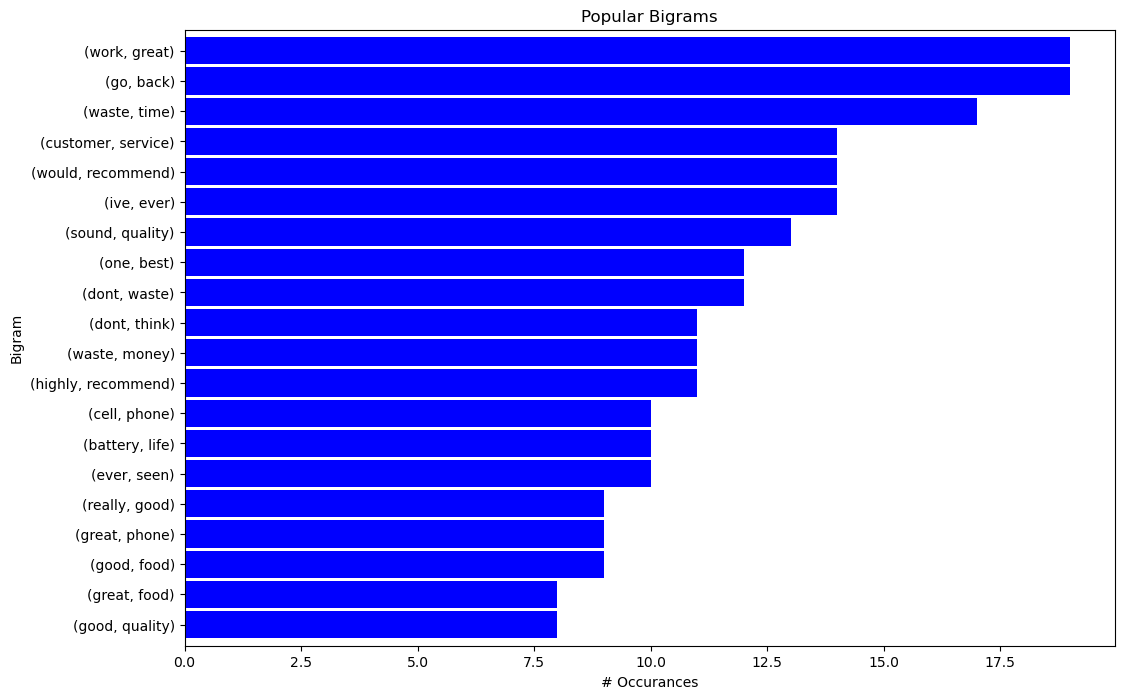

In [22]:
viz_bigrams(df, 'text', 'Popular Bigrams')

In [23]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Max sequence embedding: ' + str(max_sequence_embedding))

Max sequence embedding: 8


In [24]:
list_of_lens = []
for index, row in df.iterrows():
    list_of_lens.append(len(clean_sentence(row['text'])))
sequence_length = max(list_of_lens)
print('Sequence length: ' + str(sequence_length))

Sequence length: 789


In [25]:
sequence_length = max(list_of_lens)
mean_sequence_length = int(round(np.mean(list_of_lens), 0))
print('Mean sequence length: ' + str(mean_sequence_length))

Mean sequence length: 7


## B2. Goals of the Tokenization Process (source: D213 Webinars)
The goal of the tokenization process for this analysis includes normalization, removing stopwords, encoding/decoding, removing special characters, fixing capitalization, and lemmatization. Essentially, we want to take the sentences from the reviews and make them into an array of characters, or a token, to then be run through the model.

In [26]:
df['cleaned_text'] = df["text"].apply(clean_sentence)

In [27]:
df.head()

,text,label,cleaned_text
0,So there is no way for me to plug it in here i...,0,"[way, plug, u, unless, go, converter]"
1,"Good case, Excellent value.",1,"[good, case, excellent, value]"
2,Great for the jawbone.,1,"[great, jawbone]"
3,Tied to charger for conversations lasting more...,0,"[tied, charger, conversation, lasting, 45, min..."
4,The mic is great.,1,"[mic, great]"


In [28]:
def listToString(s):
    string = " "
    return (string.join(s))

In [29]:
df['highly_cleaned_text'] = df['cleaned_text'].apply(listToString)

In [30]:
df.head()

,text,label,cleaned_text,highly_cleaned_text
0,So there is no way for me to plug it in here i...,0,"[way, plug, u, unless, go, converter]",way plug u unless go converter
1,"Good case, Excellent value.",1,"[good, case, excellent, value]",good case excellent value
2,Great for the jawbone.,1,"[great, jawbone]",great jawbone
3,Tied to charger for conversations lasting more...,0,"[tied, charger, conversation, lasting, 45, min...",tied charger conversation lasting 45 minutesma...
4,The mic is great.,1,"[mic, great]",mic great


In [31]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [32]:
split = round(len(df)*0.8)
train_reviews = df['highly_cleaned_text'][:split]
train_label = df['label'][:split]
test_reviews = df['highly_cleaned_text'][split:]
test_label = df['label'][split:]

In [33]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [34]:
vocab_size = 4967
embedding_dim = 8
max_length = 78
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

## B3. Padding Process (source: D213 Webinars)
The padding process is a necessary part of sentiment analysis in that it allows the RNN model to process sequences of different lengths efficiently. The padding occurs before the sequence.

In [36]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [37]:
testing_padded[:1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  16,  55,  15, 109,  47,   1, 717]])

## B4. Categories of Sentiment (sources: D213 Webinars, Brownlee)
For this analysis, we want two types of sentiment for the sentiment index: binary: optimistic (positive) or pessimistic (negative). We will also have a sigmoid activiation function for the final layer.

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2)),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [41]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=2)

In [42]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, callbacks=[early_stopping_monitor], validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
69/69 [==============================] - 7s 50ms/step - loss: 0.6922 - accuracy: 0.5159 - val_loss: 0.6923 - val_accuracy: 0.4527
Epoch 2/20
69/69 [==============================] - 3s 49ms/step - loss: 0.6207 - accuracy: 0.6588 - val_loss: 0.6304 - val_accuracy: 0.6327
Epoch 3/20
69/69 [==============================] - 3s 50ms/step - loss: 0.3240 - accuracy: 0.8758 - val_loss: 0.4862 - val_accuracy: 0.7964
Epoch 4/20
69/69 [==============================] - 4s 52ms/step - loss: 0.2008 - accuracy: 0.9231 - val_loss: 0.5886 - val_accuracy: 0.7618
Epoch 5/20
69/69 [==============================] - 4s 58ms/step - loss: 0.1376 - accuracy: 0.9518 - val_loss: 0.6052 - val_accuracy: 0.7891


<Figure size 640x480 with 0 Axes>

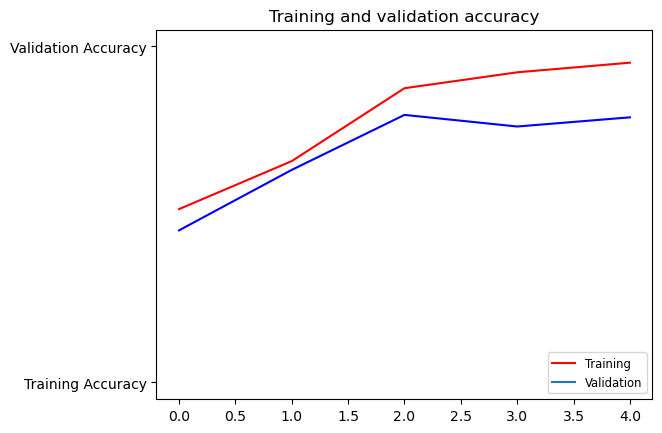

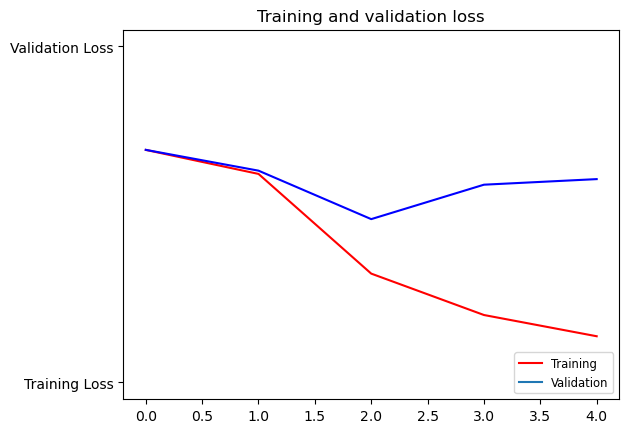

<Figure size 640x480 with 0 Axes>

In [43]:
%matplotlib inline
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy', label="Training")
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy', label="Validation")
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.figure()

## B5. Steps to Prepare the Data
The steps to prepare the data were to combine all of the Amazon, IMDB, and Yelp reviews into one dataframe, fix the index, stopwords, normalization, removing special characters, lemmatization, tokenization, and creating the test split of the 80-20 industry standard.

## B6. Copy of Prepared Dataset
Please see the prepared dataset being submitted as part of this PA.

In [44]:
x_training = pd.DataFrame(padded)
x_testing = pd.DataFrame(testing_padded)
y_training = pd.DataFrame(training_labels)
y_testing = pd.DataFrame(testing_labels)

In [45]:
x_training.to_csv('/Users/astro/Downloads/d213_task2_x_train_clean.csv')
x_testing.to_csv('/Users/astro/Downloads/d213_task2_x_test_clean.csv')
y_training.to_csv('/Users/astro/Downloads/d213_task2_y_train_clean.csv')
y_testing.to_csv('/Users/astro/Downloads/d213_task2_y_test_clean.csv')

# PART III: Network Architecture

## C1. Output of the Model Summary

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 8)             39736     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               10496     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 52,105
Trainable params: 52,105
Non-trainable params: 0
____________________________________________________

## C2. Discussion of the Layers
As we can see from the Output of the Model Summary above, there are five layers: one embedding type with 39736 parameters, one bidirectional type with 10496 parameters, and three dense types with 1560, 300, and 13 parameters, respectively. We can see that the total parameters are 52105, and the trainable parameters are also 52105.

## C3. Jutification of Hyperparameters

1. Activation Functions: As stated, a sigmoid activiation function was used for the last layer because we are looking for a binary classification of the sentiment index (positive or negative). Also, the rest consisted of a ReLU function for ease of implementation using the max function.

2. Number of Nodes per Layer: Here, we used the systematic experimentation method to determine the number of nodes per layer (source: Brownlee).

3. Loss Function: Here, we utilized the binary crossentropy loss function since, again, our sentiment index output is binary.

4. Optimizer: The optimizer used for this model was the adaptive moment estimation, or ADAM, which "uses a square gradient to scale the learning rate (an approach called adaptive learning rates), and tracks the moving average of the gradient (an approach called momentum). This makes ADAM an algorithm that is adaptive with regards to moments." (source: Medium)

5. Stopping Criteria: The stopping criteria for this model was value loss critera based on instruction in the D213 webinars because we want to minimize loss for this type of analysis.

6. Evaluation Metric: For this model, we used the accuracy evaluation metric also as per the guidance of the D213 webinars and for the ease of understanding.

# PART IV: Model Evaluation

## D1. Impact of Stopping Criteria
The stopping criteria from the value loss criteria hyperparameter caused the model to stop training at epoch 5 instead of the given epoch 20. This can be seen from the output above in part B4, and copied here:

Epoch 5/20
69/69 [==============================] - 4s 58ms/step - loss: 0.1376 - accuracy: 0.9518 - val_loss: 0.6052 - val_accuracy: 0.7891

## D2. Fitness of the Model
There may be some overfitting in this model. However, attempts to reconcile the effects on the accuracy proved fruitless (i.e., adding a dropout layer and changing hyperparameters).

## D3. Visualizations of Model's Training Process

<Figure size 640x480 with 0 Axes>

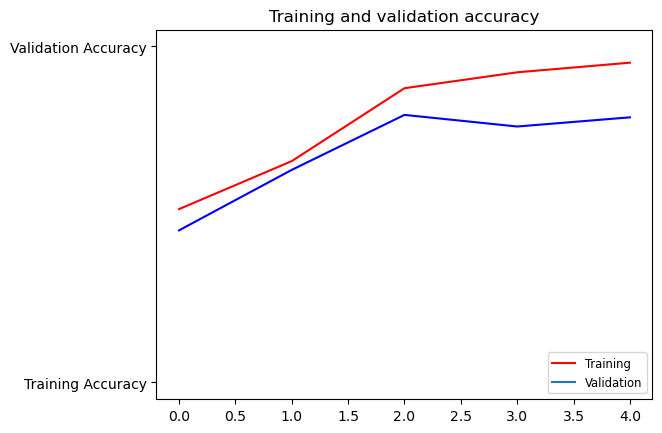

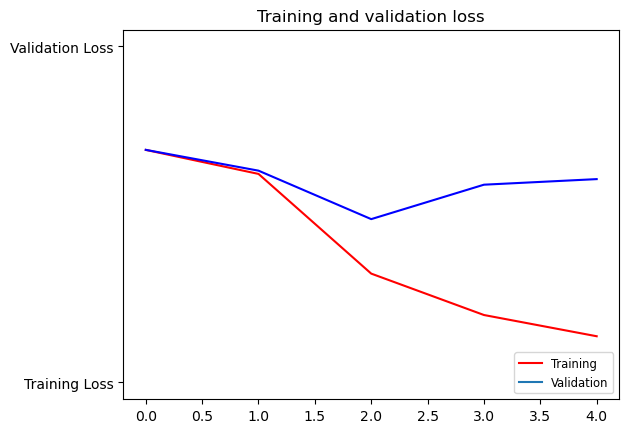

<Figure size 640x480 with 0 Axes>

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy', label="Training")
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy', label="Validation")
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.figure()

## D4. Predictive Accuracy of Trained Network
As we can see from above, the model had a predictive accuracy of 95.18% of the trained network.

# PART V: Summary and Recommendations

## E. Code Used to Save the Trained Network within the Neural Network
Please see the code above.

## F. Functionality of Neural Network (w/impact of architecture)
Unfortunately, there were some signs of overfitting with this model, but any attempts to fix it ended up making it worse, so it turns out that, despite the overfitting, the most basic version of this model was the best. There was little impact of the architecture given the overfitting.

## G. Recommended Course of Action
My recommended course of action in relation to the research question of "Can we use a Recurrent Neural Network (RNN) to find the Sentiment Index among the reviews from Amazon, IMDB, and Yelp?" for this analysis is to perform the analysis again once more reviews/data is available. I feel that this analysis would likely have turned out better if there was more data for the RNN.